In [65]:

from phenotypic.data import load_plate_72hr

(<Figure size 800x600 with 1 Axes>, <Axes: >)

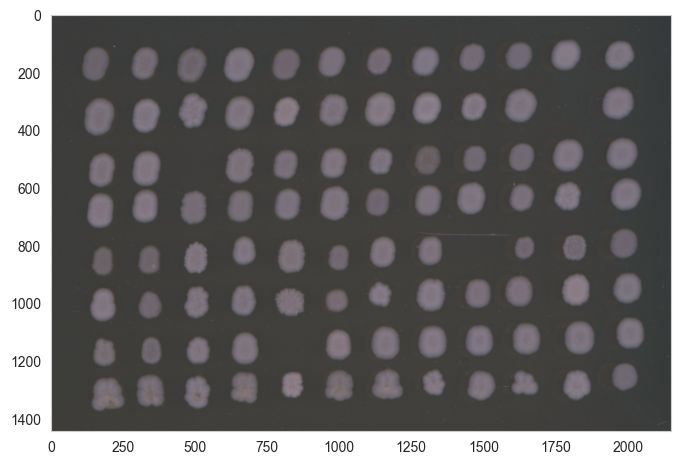

In [66]:
from phenotypic import GridImage, Image


plate_image = GridImage(load_plate_72hr(), name='Plate72Hr')
plate_image.show()

In [67]:
from skimage.color import rgb2gray
print(rgb2gray(load_plate_72hr()).dtype)

float64


In [68]:
from pympler import asizeof

print(f'Array size: {asizeof.asizeof(load_plate_72hr()) / 1000000} mbytes')
print(f'Phenotypic.GridImage: {asizeof.asizeof(plate_image) / 1000000} mbytes')
print(f'Phenotypic.Image: {asizeof.asizeof(Image(load_plate_72hr())) / 1000000} mbytes')

print(f'Ratio: {asizeof.asizeof(plate_image) / asizeof.asizeof(load_plate_72hr())}')

Array size: 9.31396 mbytes
Phenotypic.GridImage: 59.007704 mbytes
Phenotypic.Image: 59.00644 mbytes
Ratio: 6.335404489604851


In [69]:
import os, psutil

proc = psutil.Process(os.getpid())

# RSS: resident set size
rss = proc.memory_info().rss

# Full info gives you USS (unique) on Linux via memory_full_info().uss
full = proc.memory_full_info()
uss = getattr(full, "uss", None)      # Unique Set Size (Linux)
pss = getattr(full, "pss", None)      # Proportional Set Size (Linux)

print(f"RSS = {rss/1024**2:.1f} MB")
if uss is not None:
    print(f"USS = {uss/1024**2:.1f} MB")
if pss is not None:
    print(f"PSS = {pss/1024**2:.1f} MB")

RSS = 4257.5 MB
USS = 1732.9 MB


In [70]:
total_data_footprint = 0
for data_key, data_value in plate_image._data.__dict__.items():
    print(
        f'{data_key} | {data_value.dtype}: {asizeof.asizeof(data_value) / 1000000} mbytes | shape: {data_value.shape} | fold-increase: {asizeof.asizeof(data_value) / asizeof.asizeof(load_plate_72hr())}')
    total_data_footprint += asizeof.asizeof(data_value)
print(f'Total data footprint: {total_data_footprint / 1000000} mbytes')
print(f'Class overhead: {asizeof.asizeof(plate_image) / 1000000 - total_data_footprint / 1000000}')

array | uint8: 9.31396 mbytes | shape: (1444, 2150, 3) | fold-increase: 1.0
matrix | float64: 24.83696 mbytes | shape: (1444, 2150) | fold-increase: 2.666638035808614
enh_matrix | float64: 24.83696 mbytes | shape: (1444, 2150) | fold-increase: 2.666638035808614
sparse_object_map | uint16: 0.009904 mbytes | shape: (1444, 2150) | fold-increase: 0.001063350068069865
Total data footprint: 58.997784 mbytes
Class overhead: 0.009919999999993934


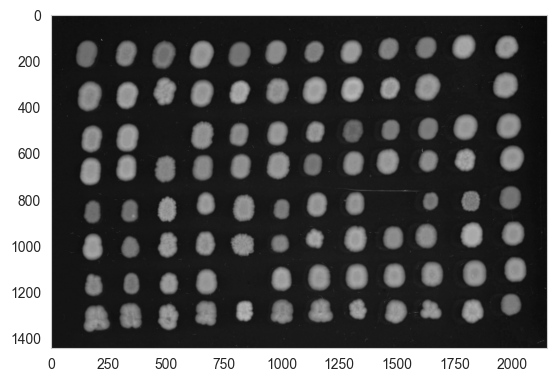

In [71]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
fig, ax = plt.subplots()
ax.grid(False)
ax.imshow(rgb2gray(plate_image.array[:]), cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

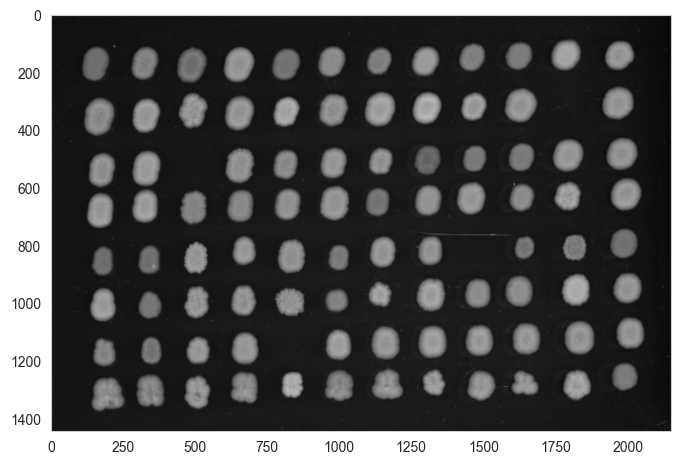

In [72]:
plate_image.matrix.show()

(<Figure size 1000x500 with 2 Axes>,
 array([ (<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': 'Plate72Hr'}>),
        <Axes: >], dtype=object))

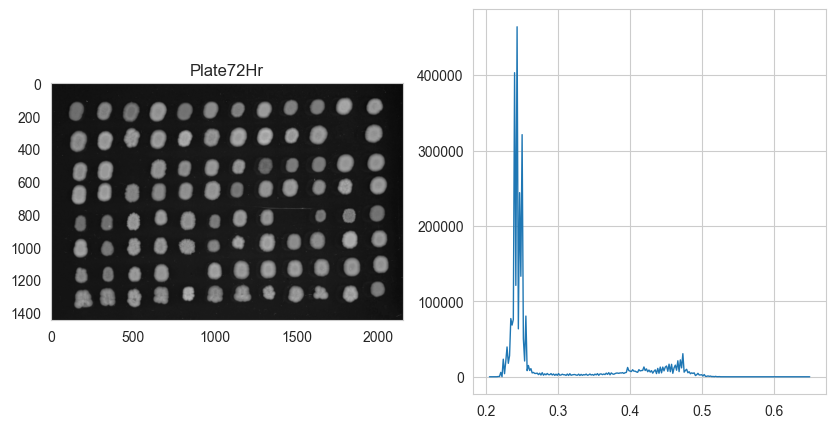

In [73]:
plate_image.enh_matrix.histogram()

(<Figure size 900x1000 with 1 Axes>, <Axes: >)

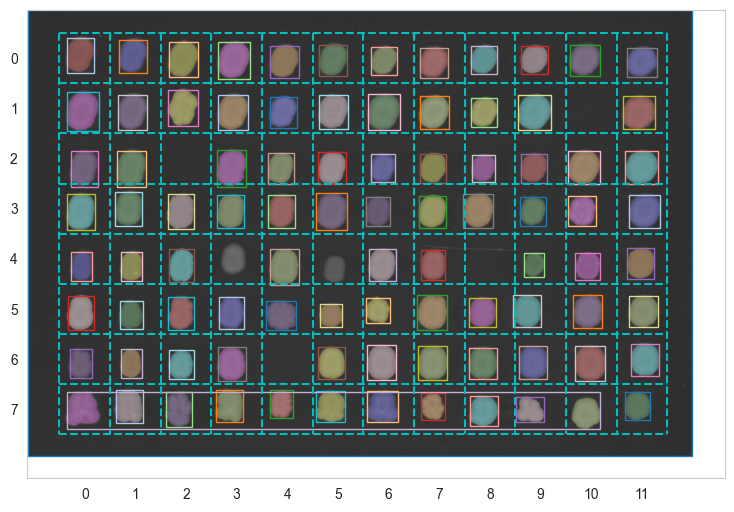

In [74]:
from phenotypic import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import WatershedDetector
from phenotypic.correction import GridAligner, GammaDecoder
from phenotypic.grid import GridApply, MinResidualErrorReducer, GridAlignmentOutlierRemover
from phenotypic.objedit import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
from phenotypic.morphology import MaskFill

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    ops={
        'blur': GaussianSmoother(sigma=5),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': WatershedDetector(footprint='auto', min_size=50, relabel=True),
        'mask_fill':MaskFill(),
        'RemoveBorderObjects': BorderObjectRemover(),
        'low circularity remover': LowCircularityRemover(0.7),
        'reduce by section residual error': MinResidualErrorReducer(),
        'outlier removal': GridAlignmentOutlierRemover(),
        'align': GridAligner(),
        'grid_reduction': MinResidualErrorReducer(),
    },
    meas={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture(scale=3),
        'MeasureTexture2': MeasureTexture(scale=4),
    }
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()


(<Figure size 1000x500 with 2 Axes>,
 array([ (<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': 'Plate72Hr'}>),
        <Axes: >], dtype=object))

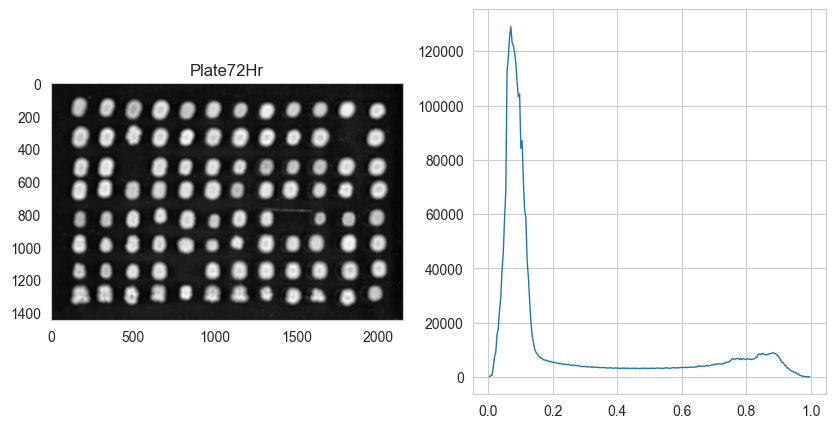

In [75]:
pipeline_output.enh_matrix.histogram()

In [76]:
pipeline_meas = kmarx_pipeline.measure(pipeline_output, include_metadata=False)
pipeline_meas

,Metadata_BitDepth,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,DifferenceEntropyIntensity-deg(90)-scale(4)),DifferenceEntropyIntensity-deg(135)-scale(4)),InformationCorrelation1Intensity-deg(0)-scale(4)),InformationCorrelation1Intensity-deg(45)-scale(4)),InformationCorrelation1Intensity-deg(90)-scale(4)),InformationCorrelation1Intensity-deg(135)-scale(4)),InformationCorrelation2Intensity-deg(0)-scale(4)),InformationCorrelation2Intensity-deg(45)-scale(4)),InformationCorrelation2Intensity-deg(90)-scale(4)),InformationCorrelation2Intensity-deg(135)-scale(4))
0,8,GridImage,b'',Plate72Hr,1,146.389728,171.025220,92,129,204,...,2.153988,2.630991,-0.282260,-0.194294,-0.296109,-0.198369,0.920386,0.848588,0.929772,0.854970
1,8,GridImage,b'',Plate72Hr,2,149.320484,340.361316,96,297,204,...,2.892390,3.277090,-0.229250,-0.153775,-0.235737,-0.162932,0.924256,0.848860,0.929580,0.862525
2,8,GridImage,b'',Plate72Hr,3,160.806829,503.310931,104,457,218,...,2.652444,2.947733,-0.242220,-0.152738,-0.255330,-0.181143,0.926494,0.839233,0.934571,0.875339
3,8,GridImage,b'',Plate72Hr,4,163.592914,667.372290,105,616,223,...,2.962660,3.356956,-0.307088,-0.214174,-0.302193,-0.219376,0.964416,0.916461,0.963146,0.920944
4,8,GridImage,b'',Plate72Hr,5,162.582913,988.458851,112,944,214,...,2.841616,3.320149,-0.307027,-0.211007,-0.278132,-0.208404,0.957299,0.901606,0.946291,0.900814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8,GridImage,b'',Plate72Hr,86,1293.564356,489.112486,1238,447,1349,...,3.304657,3.827585,-0.224511,-0.147989,-0.222629,-0.146923,0.938514,0.867260,0.938179,0.865387
86,8,GridImage,b'',Plate72Hr,87,1283.914791,1311.578175,1240,1275,1327,...,3.583622,4.020727,-0.222454,-0.159079,-0.217978,-0.149905,0.941739,0.887311,0.939545,0.875588
87,8,GridImage,b'',Plate72Hr,88,1298.131035,1475.668566,1249,1431,1348,...,3.093299,3.474010,-0.290217,-0.207556,-0.274412,-0.202269,0.968473,0.927799,0.963337,0.924276
88,8,GridImage,b'',Plate72Hr,89,1296.695274,1624.837045,1252,1581,1335,...,3.536816,3.978413,-0.262694,-0.185560,-0.243030,-0.187543,0.962666,0.916361,0.954269,0.917514


(<Figure size 800x600 with 1 Axes>, <Axes: >)

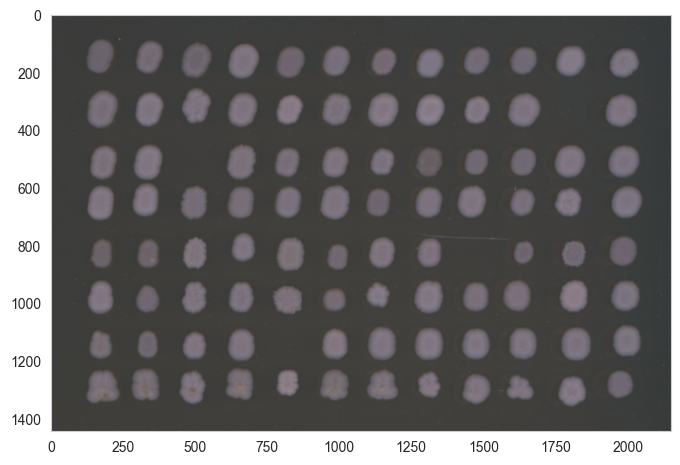

In [77]:
pipeline_output.array.show()

min: 0.17333218455314636 max: 0.727141797542572


<Axes: ylabel='Count'>

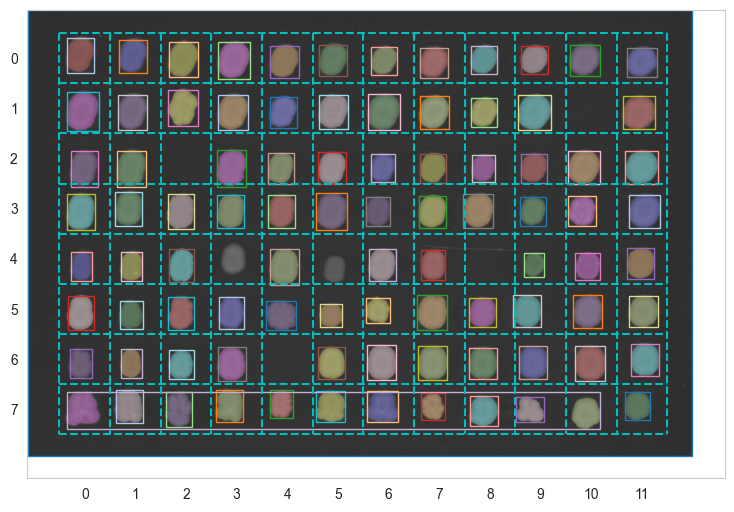

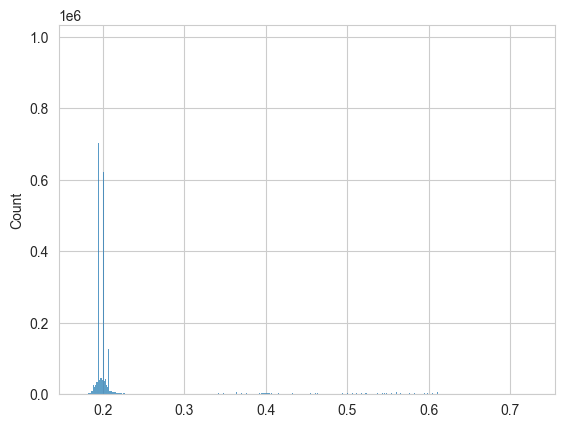

In [78]:
fig, ax = pipeline_output.show_overlay()
overlay_arr = ax.images[0].get_array()

import seaborn as sns
import matplotlib.pyplot as plt
hist_fig, hist_ax = plt.subplots()
print(f'min: {overlay_arr.min()} max: {overlay_arr.max()}')
sns.histplot(overlay_arr.ravel(), ax=hist_ax)

In [79]:
CLAHE.__name__

'CLAHE'

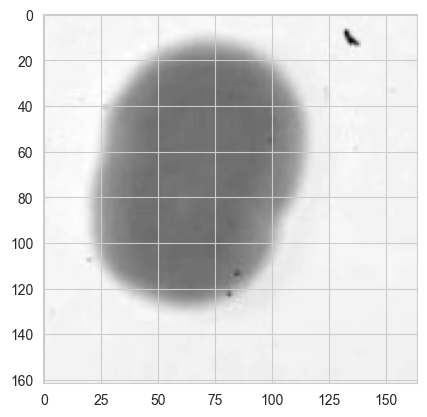

In [80]:
colony_image = pipeline_output.grid[0]
from skimage.util import invert
colony_matrix = invert(colony_image.matrix[:])

import matplotlib.pyplot as plt
plt.imshow(colony_matrix, cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

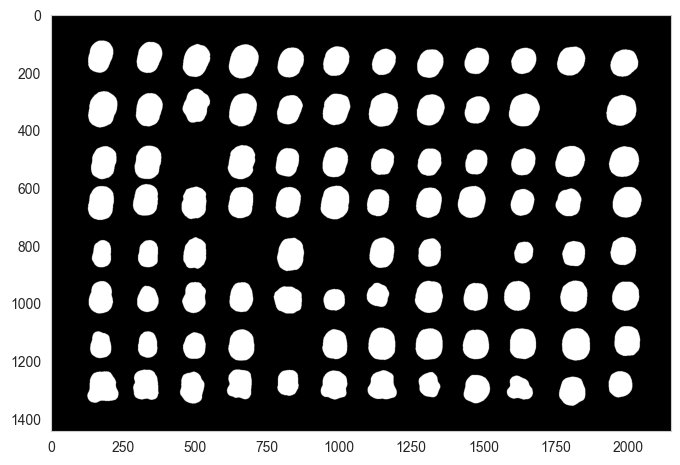

In [81]:
pipeline_output.objmask.show()

In [83]:
pipeline_output.grid.info()

,Metadata_BitDepth,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_RowInterval,Grid_ColNum,Grid_ColInterval,Grid_SectionIndex,Grid_SectionNum
0,8,GridImage,b'',Plate72Hr,1,146.389728,171.025220,92,129,204,216,0,"(76, 238)",0,"(103, 267)","(0, 0)",0
1,8,GridImage,b'',Plate72Hr,2,149.320484,340.361316,96,297,204,386,0,"(76, 238)",1,"(267, 431)","(0, 1)",1
2,8,GridImage,b'',Plate72Hr,3,160.806829,503.310931,104,457,218,552,0,"(76, 238)",2,"(431, 595)","(0, 2)",2
3,8,GridImage,b'',Plate72Hr,4,163.592914,667.372290,105,616,223,721,0,"(76, 238)",3,"(595, 759)","(0, 3)",3
4,8,GridImage,b'',Plate72Hr,5,162.582913,988.458851,112,944,214,1035,0,"(76, 238)",5,"(923, 1087)","(0, 5)",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8,GridImage,b'',Plate72Hr,86,1293.564356,489.112486,1238,447,1349,532,7,"(1211, 1373)",2,"(431, 595)","(7, 2)",86
86,8,GridImage,b'',Plate72Hr,87,1283.914791,1311.578175,1240,1275,1327,1350,7,"(1211, 1373)",7,"(1251, 1415)","(7, 7)",91
87,8,GridImage,b'',Plate72Hr,88,1298.131035,1475.668566,1249,1431,1348,1523,7,"(1211, 1373)",8,"(1415, 1579)","(7, 8)",92
88,8,GridImage,b'',Plate72Hr,89,1296.695274,1624.837045,1252,1581,1335,1671,7,"(1211, 1373)",9,"(1579, 1743)","(7, 9)",93


In [84]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements

,ObjectLabel,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_MedianRadius,Shape_MeanRadius,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength,Shape_Compactness,Shape_Orientation
0,1,7613.0,335.563492,0.849603,316.517210,14.000000,15.658120,0.697679,24.052405,0.781301,9744.0,116.511637,83.470191,1.177020,-0.295205
1,2,7445.0,330.149278,0.858329,311.469473,14.000000,15.638814,0.667029,23.902824,0.774553,9612.0,112.947968,84.149837,1.165054,-0.340896
2,3,8288.0,348.291414,0.858567,328.237068,14.764823,16.526457,0.650268,25.250043,0.765282,10830.0,117.988329,89.636289,1.164732,-0.378287
3,4,9455.0,369.362482,0.870895,348.749593,16.000000,17.861013,0.605939,27.111143,0.763115,12390.0,123.119680,97.943036,1.148244,-0.405697
4,5,7327.0,322.492424,0.885313,306.337331,14.000000,15.824517,0.593671,23.918077,0.789377,9282.0,107.748365,86.705934,1.129544,-0.433380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,7272.0,331.320851,0.832465,311.484939,13.601471,15.143153,0.670905,23.346233,0.770747,9435.0,112.079039,83.111471,1.201251,0.022526
86,87,4976.0,269.036580,0.863908,255.293855,11.401754,12.770168,0.568069,19.491264,0.762605,6525.0,88.076298,72.485089,1.157530,0.207409
87,88,7021.0,317.078210,0.877558,300.026625,13.892444,15.540999,0.450041,23.401256,0.770861,9108.0,100.315608,89.582614,1.139525,-0.340076
88,89,5523.0,293.764502,0.804241,275.439489,11.401754,12.701294,0.498848,20.051591,0.739357,7470.0,91.865102,79.618503,1.243408,0.993205


In [85]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements

,ObjectLabel,Intensity_IntegratedIntensity,Intensity_MinimumIntensity,Intensity_MaximumIntensity,Intensity_MeanIntensity,Intensity_MedianIntensity,Intensity_StandardDeviationIntensity,Intensity_CoefficientVarianceIntensity,Intensity_LowerQuartileIntensity,Intensity_UpperQuartileIntensity,Intensity_InterquartileRangeIntensity
0,1,2933.874447,0.311414,0.444406,0.385377,0.394091,0.017653,0.045813,0.376276,0.397692,0.021415
1,2,3082.431938,0.310375,0.449211,0.414027,0.424592,0.028504,0.068856,0.399409,0.434584,0.035175
2,3,3275.395408,0.321175,0.431167,0.395197,0.398831,0.021245,0.053765,0.385686,0.411761,0.026076
3,4,4199.409110,0.312269,0.483593,0.444147,0.459015,0.035895,0.080826,0.428050,0.470267,0.042217
4,5,3103.445762,0.304351,0.457368,0.423563,0.442279,0.033744,0.079678,0.406192,0.448689,0.042497
...,...,...,...,...,...,...,...,...,...,...,...
85,86,3202.887343,0.303680,0.499247,0.440441,0.452615,0.036118,0.082016,0.418380,0.469008,0.050628
86,87,2213.072627,0.301746,0.506686,0.444749,0.458502,0.041264,0.092799,0.421128,0.476198,0.055069
87,88,3095.907866,0.325562,0.495497,0.440950,0.454311,0.036600,0.083014,0.415938,0.469933,0.053995
88,89,2373.403791,0.288712,0.489309,0.429731,0.444234,0.042509,0.098939,0.402398,0.464500,0.062101


In [86]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements

,ObjectLabel,AngularSecondMomentIntensity-deg(0)-scale(5)),AngularSecondMomentIntensity-deg(45)-scale(5)),AngularSecondMomentIntensity-deg(90)-scale(5)),AngularSecondMomentIntensity-deg(135)-scale(5)),ContrastIntensity-deg(0)-scale(5)),ContrastIntensity-deg(45)-scale(5)),ContrastIntensity-deg(90)-scale(5)),ContrastIntensity-deg(135)-scale(5)),CorrelationIntensity-deg(0)-scale(5)),...,DifferenceEntropyIntensity-deg(90)-scale(5)),DifferenceEntropyIntensity-deg(135)-scale(5)),InformationCorrelation1Intensity-deg(0)-scale(5)),InformationCorrelation1Intensity-deg(45)-scale(5)),InformationCorrelation1Intensity-deg(90)-scale(5)),InformationCorrelation1Intensity-deg(135)-scale(5)),InformationCorrelation2Intensity-deg(0)-scale(5)),InformationCorrelation2Intensity-deg(45)-scale(5)),InformationCorrelation2Intensity-deg(90)-scale(5)),InformationCorrelation2Intensity-deg(135)-scale(5))
0,1,0.053166,0.048860,0.056599,0.050400,8.512472,12.454905,7.055316,10.967733,0.707670,...,2.273970,2.790713,-0.239618,-0.156261,-0.257964,-0.155517,0.890886,0.797504,0.907007,0.799196
1,2,0.011008,0.009445,0.011236,0.009924,22.768830,38.862002,17.163429,28.626307,0.713017,...,3.099870,3.479363,-0.181421,-0.114054,-0.186633,-0.120412,0.883037,0.779670,0.890006,0.794682
2,3,0.013533,0.011679,0.015515,0.013180,12.298264,22.137512,10.773210,16.874359,0.736025,...,2.866960,3.159251,-0.190023,-0.104726,-0.201190,-0.131999,0.884369,0.750405,0.895638,0.806553
3,4,0.016269,0.012609,0.017906,0.014564,26.848505,45.803833,25.292044,39.011480,0.787588,...,3.143216,3.553185,-0.261009,-0.168454,-0.257143,-0.174104,0.945549,0.871719,0.944159,0.879190
4,5,0.027632,0.024713,0.028547,0.025721,24.835998,44.826517,24.990396,36.112925,0.778043,...,3.007436,3.496957,-0.269429,-0.171475,-0.237508,-0.167286,0.940471,0.859932,0.923318,0.856840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,0.005044,0.004336,0.005156,0.004236,37.357100,56.033769,32.176110,59.264350,0.718140,...,3.530117,4.042268,-0.180310,-0.104568,-0.176567,-0.108920,0.904070,0.790424,0.901650,0.799222
86,87,0.003916,0.003398,0.003898,0.003280,49.510240,75.829710,46.964573,79.845785,0.708500,...,3.804731,4.224031,-0.179541,-0.119938,-0.174906,-0.110888,0.908806,0.828385,0.905172,0.810344
87,88,0.005614,0.004713,0.005976,0.004879,23.368147,39.458016,22.665092,36.759780,0.834244,...,3.305107,3.690273,-0.250509,-0.167278,-0.227815,-0.160053,0.953041,0.891075,0.941541,0.883424
88,89,0.004472,0.003713,0.004397,0.003985,36.866811,64.193791,46.040450,75.901609,0.805680,...,3.753911,4.191071,-0.221414,-0.147057,-0.199561,-0.147178,0.942522,0.873874,0.927957,0.873322


,ObjectLabel,Color_L*,Color_L*LowerQuartile,Color_L*Mean,Color_L*Median,Color_L*UpperQuartile,Color_L*Maximum,Color_L*StdDev,Color_L*CoefficientVariance,Color_a*,...,Color_BrightnessMinimum,Color_BrightnessLowerQuartile,Color_BrightnessMean,Color_BrightnessMedian,Color_BrightnessUpperQuartile,Color_BrightnessMaximum,Color_BrightnessStdDev,Color_BrightnessCoefficientVariance,Color_ChromaEstimatedMean,Color_ChromaEstimatedMedian
0,1,62.627016,67.745690,68.395024,69.047082,69.305304,72.522380,1.318999,0.019288,0.359383,...,0.319538,0.399154,0.410361,0.417632,0.425925,0.464044,0.021640,0.052741,3.892572,3.843314
1,2,62.539531,69.427680,70.409568,71.186971,71.865387,72.840400,2.048784,0.029102,0.388258,...,0.321166,0.426260,0.441228,0.454737,0.463474,0.478431,0.031533,0.071475,4.001126,4.289409
2,3,63.440181,68.437987,69.098298,69.386663,70.299569,71.634485,1.553766,0.022489,0.320337,...,0.332307,0.406564,0.418295,0.424850,0.435787,0.458824,0.024099,0.057619,3.547127,3.658586
3,4,62.698815,71.422908,72.436175,73.482128,74.207375,75.051617,2.491025,0.034393,0.275044,...,0.327658,0.458356,0.475579,0.492235,0.503286,0.525370,0.040053,0.084228,4.326897,4.673447
4,5,62.027989,69.908694,71.050670,72.381064,72.806019,73.374950,2.407463,0.033888,-0.015056,...,0.317844,0.433475,0.454867,0.474340,0.482941,0.498006,0.039870,0.087665,4.243613,4.653612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,61.970702,70.759531,72.188565,73.064260,74.126787,76.023562,2.497035,0.034595,0.336957,...,0.316838,0.451508,0.472423,0.486981,0.501961,0.533333,0.040174,0.085049,3.906673,4.271715
86,87,61.804676,70.949140,72.454945,73.448785,74.585051,76.478336,2.846002,0.039288,0.334212,...,0.314509,0.451203,0.476879,0.493099,0.511900,0.551030,0.046778,0.098111,4.132379,4.390511
87,88,63.800141,70.590395,72.221512,73.175413,74.186013,75.792477,2.513012,0.034801,0.491922,...,0.343610,0.442768,0.469959,0.485495,0.501961,0.532111,0.040486,0.086161,3.961970,4.196016
88,89,60.667799,69.640301,71.435958,72.511094,73.836994,75.408810,2.993397,0.041911,-0.014208,...,0.301913,0.426895,0.458075,0.476534,0.496357,0.531672,0.048430,0.105744,3.685692,3.830387


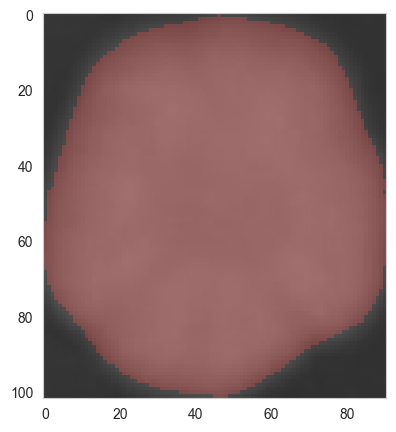

In [87]:
single_object = pipeline_output.objects[-1]
fig, ax = single_object.show_overlay()
color_measurements =MeasureColor().measure(pipeline_output)
color_measurements

In [88]:
color_measurements

,ObjectLabel,Color_L*,Color_L*LowerQuartile,Color_L*Mean,Color_L*Median,Color_L*UpperQuartile,Color_L*Maximum,Color_L*StdDev,Color_L*CoefficientVariance,Color_a*,...,Color_BrightnessMinimum,Color_BrightnessLowerQuartile,Color_BrightnessMean,Color_BrightnessMedian,Color_BrightnessUpperQuartile,Color_BrightnessMaximum,Color_BrightnessStdDev,Color_BrightnessCoefficientVariance,Color_ChromaEstimatedMean,Color_ChromaEstimatedMedian
0,1,62.627016,67.745690,68.395024,69.047082,69.305304,72.522380,1.318999,0.019288,0.359383,...,0.319538,0.399154,0.410361,0.417632,0.425925,0.464044,0.021640,0.052741,3.892572,3.843314
1,2,62.539531,69.427680,70.409568,71.186971,71.865387,72.840400,2.048784,0.029102,0.388258,...,0.321166,0.426260,0.441228,0.454737,0.463474,0.478431,0.031533,0.071475,4.001126,4.289409
2,3,63.440181,68.437987,69.098298,69.386663,70.299569,71.634485,1.553766,0.022489,0.320337,...,0.332307,0.406564,0.418295,0.424850,0.435787,0.458824,0.024099,0.057619,3.547127,3.658586
3,4,62.698815,71.422908,72.436175,73.482128,74.207375,75.051617,2.491025,0.034393,0.275044,...,0.327658,0.458356,0.475579,0.492235,0.503286,0.525370,0.040053,0.084228,4.326897,4.673447
4,5,62.027989,69.908694,71.050670,72.381064,72.806019,73.374950,2.407463,0.033888,-0.015056,...,0.317844,0.433475,0.454867,0.474340,0.482941,0.498006,0.039870,0.087665,4.243613,4.653612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,61.970702,70.759531,72.188565,73.064260,74.126787,76.023562,2.497035,0.034595,0.336957,...,0.316838,0.451508,0.472423,0.486981,0.501961,0.533333,0.040174,0.085049,3.906673,4.271715
86,87,61.804676,70.949140,72.454945,73.448785,74.585051,76.478336,2.846002,0.039288,0.334212,...,0.314509,0.451203,0.476879,0.493099,0.511900,0.551030,0.046778,0.098111,4.132379,4.390511
87,88,63.800141,70.590395,72.221512,73.175413,74.186013,75.792477,2.513012,0.034801,0.491922,...,0.343610,0.442768,0.469959,0.485495,0.501961,0.532111,0.040486,0.086161,3.961970,4.196016
88,89,60.667799,69.640301,71.435958,72.511094,73.836994,75.408810,2.993397,0.041911,-0.014208,...,0.301913,0.426895,0.458075,0.476534,0.496357,0.531672,0.048430,0.105744,3.685692,3.830387


In [89]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output, include_metadata=False)

In [90]:
pipeline_measurements

,Metadata_BitDepth,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,DifferenceEntropyIntensity-deg(90)-scale(4)),DifferenceEntropyIntensity-deg(135)-scale(4)),InformationCorrelation1Intensity-deg(0)-scale(4)),InformationCorrelation1Intensity-deg(45)-scale(4)),InformationCorrelation1Intensity-deg(90)-scale(4)),InformationCorrelation1Intensity-deg(135)-scale(4)),InformationCorrelation2Intensity-deg(0)-scale(4)),InformationCorrelation2Intensity-deg(45)-scale(4)),InformationCorrelation2Intensity-deg(90)-scale(4)),InformationCorrelation2Intensity-deg(135)-scale(4))
0,8,GridImage,b'',Plate72Hr,1,146.389728,171.025220,92,129,204,...,2.153988,2.630991,-0.282260,-0.194294,-0.296109,-0.198369,0.920386,0.848588,0.929772,0.854970
1,8,GridImage,b'',Plate72Hr,2,149.320484,340.361316,96,297,204,...,2.892390,3.277090,-0.229250,-0.153775,-0.235737,-0.162932,0.924256,0.848860,0.929580,0.862525
2,8,GridImage,b'',Plate72Hr,3,160.806829,503.310931,104,457,218,...,2.652444,2.947733,-0.242220,-0.152738,-0.255330,-0.181143,0.926494,0.839233,0.934571,0.875339
3,8,GridImage,b'',Plate72Hr,4,163.592914,667.372290,105,616,223,...,2.962660,3.356956,-0.307088,-0.214174,-0.302193,-0.219376,0.964416,0.916461,0.963146,0.920944
4,8,GridImage,b'',Plate72Hr,5,162.582913,988.458851,112,944,214,...,2.841616,3.320149,-0.307027,-0.211007,-0.278132,-0.208404,0.957299,0.901606,0.946291,0.900814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8,GridImage,b'',Plate72Hr,86,1293.564356,489.112486,1238,447,1349,...,3.304657,3.827585,-0.224511,-0.147989,-0.222629,-0.146923,0.938514,0.867260,0.938179,0.865387
86,8,GridImage,b'',Plate72Hr,87,1283.914791,1311.578175,1240,1275,1327,...,3.583622,4.020727,-0.222454,-0.159079,-0.217978,-0.149905,0.941739,0.887311,0.939545,0.875588
87,8,GridImage,b'',Plate72Hr,88,1298.131035,1475.668566,1249,1431,1348,...,3.093299,3.474010,-0.290217,-0.207556,-0.274412,-0.202269,0.968473,0.927799,0.963337,0.924276
88,8,GridImage,b'',Plate72Hr,89,1296.695274,1624.837045,1252,1581,1335,...,3.536816,3.978413,-0.262694,-0.185560,-0.243030,-0.187543,0.962666,0.916361,0.954269,0.917514
